# IGS Zygote / SCD Analysis


Concerning SCD detection and size + lamin analysis. See Fig 5. of Payne et al. 2020.

# 0. Intializations

In [1]:
import random, os, sys, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

from source import const
from source import matrixtools as mt
from source import scdtools as scd
from source import scaling as sc
from source import comp as comp

from scipy.stats import ks_2samp
from scipy.stats import iqr
from scipy.stats import binned_statistic

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}

mpl.rcParams.update(new_rc_params)
mpl.rcParams['figure.dpi']= 300

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
datapath = "../data/Table_S2_embryo_data_table.csv"
embryo_data = pd.read_csv(datapath,index_col=False)

# Filter extrachromosomal reads
embryo_data = embryo_data.loc[embryo_data["inlier"]!=0]

num_chrs = len(const.SIZES_MM10[1:-1]) # since 1-indexed and unmappable ChrY in mouse

#retrieve zygotes
zygotes = embryo_data.loc[embryo_data["stage"] == "zygote"]
zygotes = zygotes.loc[zygotes["chr"] < num_chrs + 1]
zygotes_mat = zygotes.loc[zygotes["cluster"] == 1] # 1 = maternal, 2 = paternal
zygotes_pat = zygotes.loc[zygotes["cluster"] == 2]

# 1. Scaling
Examine the scaling properties of the parental genomes in the zygote.

In [3]:
def do_scaling_analysis(zygotes_mat, zygotes_pat, num_chrs):
    """
    Construct scaling curves for genomic and spatial distance, for the ensemble and
    for single cells.
    Params:
    -------
        zygotes_mat, zygotes_pat: dataframes for the two genomes across the dataset
        num_chrs: array of chromosome nums to include in analysis
    Returns:
    -------
        fig, ax: figure and axes for the scaling plot.
    """
    chr_nums = np.arange(1, num_chrs+1)
    
    mat_cells, pat_cells, mat_clusters, pat_clusters = [], [], [], []
    pat_cells_clusters, mat_cells_clusters = [],[]

    cell_indexes = zygotes_pat["cell_index"].unique()
    for ci in cell_indexes:
        mat_cells.append(zygotes_mat.loc[zygotes_mat["cell_index"] == ci])
        pat_cells.append(zygotes_pat.loc[zygotes_pat["cell_index"] == ci])

    #retrive all single chromosome copies
    pat_clusters, pat_cells_clusters = sc.cluster_helper(pat_cells,chr_nums,genome="mm10")
    mat_clusters, mat_cells_clusters = sc.cluster_helper(mat_cells,chr_nums,genome="mm10")
    
    P_pat, X_pat, P_mat, X_mat = [], [], [], []

    #Get the pairwise spatial and genomic distances
    for cluster in pat_clusters:
        X_pdist, P_pdist = sc.get_pdists(cluster, genome="mm10")
        X_pat.append(X_pdist)
        P_pat.append(P_pdist)

    X_pat, P_pat = np.concatenate(X_pat), np.concatenate(P_pat)

    for cluster in mat_clusters:
        X_pdist, P_pdist = sc.get_pdists(cluster,genome="mm10")
        X_mat.append(X_pdist)
        P_mat.append(P_pdist)

    X_mat, P_mat = np.concatenate(X_mat), np.concatenate(P_mat)
    
    #Construct the curves for the ensemble
    resolution = 1*10**6
    num_bins = int(np.ceil(const.SIZES_MM10[1]/resolution))
    bins = np.arange(0,num_bins)*resolution

    pat_curve, pat_edges, binnumber = binned_statistic(P_pat, X_pat, bins=bins,statistic=np.mean)
    mat_curve, mat_edges, binnumber = binned_statistic(P_mat, X_mat, bins=bins,statistic=np.mean)
    
    P_pat_cells, X_pat_cells, P_mat_cells, X_mat_cells = [],[],[],[]

    for cell in pat_cells_clusters:
        X_cell, P_cell = sc.cell_cluster_helper(cell)        
        P_pat_cells.append(P_cell)
        X_pat_cells.append(X_cell)

    for cell in mat_cells_clusters:
        X_cell, P_cell = sc.cell_cluster_helper(cell)        
        P_mat_cells.append(P_cell)
        X_mat_cells.append(X_cell)

    #Construct the curves for the single cells
    pat_cell_curves, mat_cell_curves = [], []
    for i in range(len(P_pat_cells)):
        curve, edges, binnumber = binned_statistic(P_pat_cells[i], X_pat_cells[i], bins=bins,statistic=np.mean)
        pat_cell_curves.append(curve)

    for i in range(len(P_mat_cells)):
        curve, edges, binnumber = binned_statistic(P_mat_cells[i], X_mat_cells[i], bins=bins,statistic=np.mean)
        mat_cell_curves.append(curve)
        
    #Draw the plot
    fig, ax = plt.subplots()
    rb = 140 # right bound for plotting, median MM10 chr length + some buffer

    ax.plot(edges[:rb], pat_curve[:rb], color='green',linewidth=3)
    ax.plot(edges[:rb], mat_curve[:rb], color='magenta',linewidth=3)

    for i in range(len(pat_cell_curves)):
        ax.plot(edges[:rb], pat_cell_curves[i][:rb], alpha=0.25, color='green')

    for i in range(len(pat_cell_curves)):
        ax.plot(edges[:rb], mat_cell_curves[i][:rb], alpha=0.25, color='magenta')

    ax.set_xlim(0*10**6, rb*10**6)
    ax.set_ylim(0,20)

    ax.set_xlabel("Genomic Distance [Mbp]")
    ax.set_ylabel("Spatail Distance [um]")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig, ax

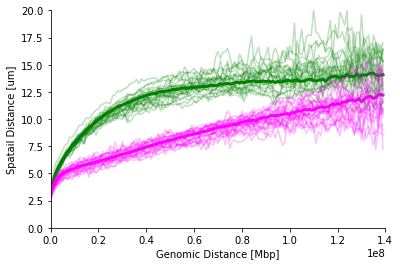

In [4]:
fig, ax = do_scaling_analysis(zygotes_mat, zygotes_pat, num_chrs)
plt.savefig("./panel_a_scaling/scaling.svg")

# 2. Comparision across Hi-C & DamID

Examine relationship between other methods and IGS.

In [5]:
#DamID lads
ladpath = "../data/external/zygote_paternal_LAD_coordinates.bed"
columns = ["chr","start","end"]
lad_data = pd.read_csv(ladpath, sep='\t', lineterminator='\n', names=columns,index_col=False)

#Hi-C compartments
compartment_path = "../data/external/PN5_rep1234_paternal_1Mb_compartments.tsv"
columns = ["chr","start","end","gc","eig","comp_ind"]
compartment_data = pd.read_csv(compartment_path, sep='\t', lineterminator='\n', names=columns,index_col=False)

In [6]:
def do_comp_analysis(data, chr_num=11, resolution=1*10**6, parent=2):
    """
    Plot the external data, then plot the IGS data, using a lamin proximity score.
    
    Params:
    -------
        cells: list of cells, dataframe
        chr_num: target chromosome
        resolution: bin resolution, in basepairs
    
    Returns:
    --------
        fig, ax: the figure and axes for the plots
    
    """
    
    num_chrs = len(const.SIZES_MM10[1:-1]) # since 1-indexed and unmappable ChrY in mouse
    cells = []
    cell_indices = data["cell_index"].unique() 

    for cell_index in cell_indices:
        cell = data.loc[data["cell_index"] == cell_index]
        cell = cell.loc[cell["chr"] < num_chrs+1]
        cell = cell.loc[cell["cluster"] == parent]
        cells.append(cell)
    
    chr_size = const.SIZES_MM10[chr_num]
    num_bins = int(np.ceil(chr_size/resolution))
    
    #retrive the target chromosome copies
    clusters, cells_clusters = sc.cluster_helper(cells,[chr_num],genome="mm10")

    #Hi-C comparment data for target chr
    comp_chr = compartment_data.loc[compartment_data["chr"]=="chr"+str(chr_num)]
    E = comp_chr["eig"].values

    #bin vector
    B = np.arange(0, num_bins)

    #lad start/end coordinates
    lad_chr = lad_data.loc[lad_data["chr"]=="chr"+str(chr_num)]
    start, end = lad_chr["start"].values, lad_chr["end"].values
    s_inds, e_inds = np.digitize(start, B*resolution) - 1, np.digitize(end, B*resolution) - 1

    #get the lamin proximity score vector
    T = comp.get_T(clusters, B, resolution)

    fig, axs = comp.draw_comp_plot(E, s_inds, e_inds, T, B, resolution,chr_num)
    
    return fig, axs

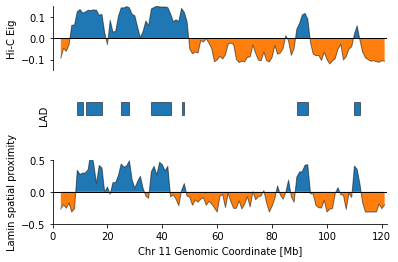

In [7]:
fig, axs = do_comp_analysis(zygotes_pat, chr_num=11, resolution=1*10**6)
plt.savefig("./panel_d_comparison/ab_lad_lamin.svg")

# 3. Filter and process high coverage chromosomes

Prepare a subset of high coverage chromosomes for downstream analysis.

In [8]:
def filter_chromosomes(data,
                       resolution = 2.5*10**6,
                       coverage_threshold=0.9,
                       statistic=np.nanmean):

    """
    Filter for chromosomes with target coverage (default 90%) at a 
    specific resolution, construct their distance matrices, 
    interpolate remaining values, and return chromosomes and matrices.   
    
    Params:
    ------- 
        data: the dataframe(must be prefiltered on stage, parent, and chr)
        resolution: the matrix resolution in basepairs
        coverage_threshold: required coverage to pass filter and be interp'd
        statistic: the metric used to compute the distance matrix
    
    Returns:
    --------
        matrices: a list of distance matrices, one per chromsome
        clusters: a list of dataframes, filtered to a singel chromosome each

    """
    
    cell_indexes = data["cell_index"].unique()
    cells, matrices, clusters = [], [], []

    for ci in cell_indexes:
        cell = data.loc[data["cell_index"] == ci]
        cells.append(cell)

    for cell in cells:
        chr_nums = cell["chr"].unique().astype(int)
        for chr_num in chr_nums:
            
            cluster = cell.loc[cell["chr"] == chr_num]
            A = mt.make_distance_matrix(cluster, resolution=resolution,statistic=statistic)

            #exclude low-coverage matrices (number of missing rows)
            coverage = mt.check_coverage(A,chr_num)
            if coverage < coverage_threshold: continue

            #interpolate gaps in remaining high-coverage matrices
            interp = mt.interpolate_missing(A)
            
            matrices.append(interp)
            clusters.append(cluster)
    
    print(str(len(matrices)) + " chromosomes" + " passing filter.")
    
    return matrices, clusters

In [9]:
#get distance matrices and corresponding clusters
matrices, clusters = filter_chromosomes(zygotes_pat, resolution = 2.5*10**6, coverage_threshold=0.9,statistic=np.nanmean)

205 chromosomes passing filter.


# 4. Distance Matrix Visualization

Visualize single-cell and ensemble distance matrices.

In [10]:
def show_scd_distance_matrix(M, C, 
                             res=2.5, 
                             clim=(3,24),
                             chr_num = 11):
    """
        Draw a distance matrix formatted for display in a figure, with rectangles
        drawn and aligned underneath to denote regions spanning pairs of SCD boundaries.
    
    Params:
    -------
        A: distance matrix for a single chromosome
        C: dataframe corresponding to a single chromosome
        res: resolution of the matrix, in megabases (not bases)
        clim: colormap limits
        
        
    Returns:
    --------
        fig, axs: fig and ax with formatted distance matrix and aligned scd bars
    """
    
    #Two axes, one for distance matrix and one for colorbars
    fig, axs = plt.subplots(nrows=2, ncols=1)
    
    #Draw distance matrix first
    fig, axs[0], cax = mt.draw_distance_mat(fig, axs[0], M, res, clim, chr_num) 
    
    #Identify SCD peaks in matrix
    peaks, dists = scd.get_scd_peaks(M)
    peaks = peaks*res
    
    #Draw and align scd bars
    axs = mt.draw_scd_bars(axs,peaks)
    fig, axs = mt.align_scd_bars(fig,axs,cax,M,res)
    
    fig.set_size_inches(8,8)
    plt.show()    

    return (fig, axs)


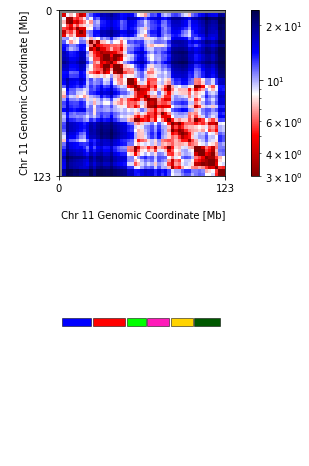

<Figure size 432x288 with 0 Axes>

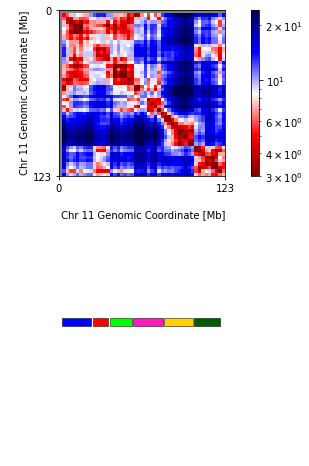

<Figure size 432x288 with 0 Axes>

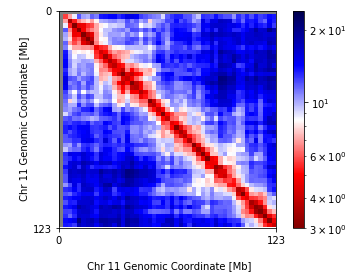

In [11]:
#Define sample chromosomes
idx1, idx2 = 33, 47 #embryo 7, chr 11 and embryo 8, chr 11 
A1, C1, A2, C2 = matrices[idx1], clusters[idx1], matrices[idx2], clusters[idx2]
#Define distance matrix clims corresponding to 1st and 99th percentile pixel values
clims = mt.get_clims([A1,A2], 1)

#Do the single cell matrix plots
(fig, ax) = show_scd_distance_matrix(A1, C1, res=2.5, clim=clims, chr_num=11)
plt.savefig("./panel_e_single_cells/embryo7_chr11pat.svg")

(fig, ax) = show_scd_distance_matrix(A2, C2, res=2.5, clim=clims, chr_num=11)
plt.savefig("./panel_e_single_cells/embryo8_chr11pat.svg")

#Construct ensemble matrix. Use all chromosomes here. Keep single cell clim for comparison.
A_e = mt.make_ensemble_matrix(zygotes_pat, chr_num = 11)

#Do the ensemble matrix plot
fig, ax = plt.subplots()
(fig, ax, cax) = mt.draw_distance_mat(fig, ax, A_e, res = 2.5, clim=clims)
plt.savefig("./panel_c_ensemble/ensemble.svg")

# 5. SCD Ensemble Properties

Examine ensemble properties of single-cell domains.

# 5.1 Sizes

In [12]:
def do_size_analysis(matrices,
                    res = 2.5,
                    bins = 20):
    """
    Measure all distances separating pairs of SCD peaks, and plot
    their histogram. 
    
    Params:
    -------
        matrices: list of distance matrices
        res: the matrix resolution, in megabases
        bins: number of bins to be plotted in histogram
    Returns:
        fig, ax: the figure and axes for histogram
    
    """
    #distance b/w SCD boundaries
    sizes = scd.get_scd_sizes(matrices)

    #summary stats
    median = np.median(sizes*res)
    IQR = iqr(sizes*res)
    
    title = "Median = "+str(median)+" Mb; IQR = "+str(IQR) + " Mb"
    
    fig, ax = scd.draw_sizes_plot(sizes, res, bins, title)

    return fig, ax

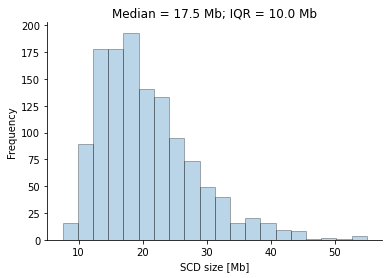

In [13]:
fig, ax = do_size_analysis(matrices)
plt.savefig("./S25_sizes/sizes.svg")

# 5.2 Boundary Strengths

In [14]:
def do_strength_analysis(data, matrices, num_chrs):
    
    """
    Compare the boundary strengths detected in single cell distance
    matrices to the boundary strengths detected in ensemble matrices.
    
    Params:
    -------
        data: the dataframe (assumed to be prefiltered on stage, parent, and chr)
        matrices: the list of high-coverage distance matrices
        num_chrs: the chromosome numbers to consider
    
    """
    #single cell and ensemble boundary strengths
    sc_strengths, ensemble_strengths = scd.get_boundary_strengths(data, matrices, num_chrs)

    #check if the two strength distributions significantly different
    p = ks_2samp(sc_strengths, ensemble_strengths)[1]
    
    #compute a 95% CI for effect size
    boot_d = scd.bootstrap_2samp(sc_strengths,ensemble_strengths,n=5000,func=scd.cohens_d)
    d_ci = boot_d(0.95)
     
    #make the plot
    title = "p = {:.2e} (K-S test); 95% CI for d: ({:.2f}, {:.2f})".format(p,d_ci[0],d_ci[1])
    fig, ax = scd.draw_strengths_plot(sc_strengths, ensemble_strengths, title)
    
    return (fig, ax)

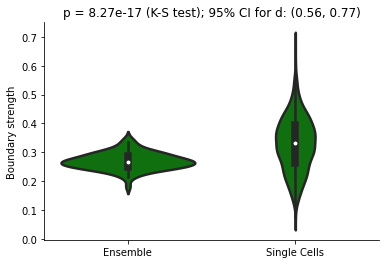

In [15]:
fig, ax  = do_strength_analysis(zygotes_pat, matrices, num_chrs)
plt.savefig("./panel_f_strengths/strengths.svg")

# 5.3 Visualize all SCDs

In [16]:
def draw_scd_ensemble(matrices, clusters, num_chrs, 
                      res=2.5,
                      filepath = "./s25_sizes/heatmap_chr" ):
    """
    Visualize regions spanning SCD boundaries in across all chromosomes in 
    all high coverage single cell distance matrices.
    
    Params:
    -------
        matrices: list of high-coverage single-cell distance matrices
        clusters: single-chromosome dataframes corresponding to matrices
        num_chrs: chromosome numbers to be cnsidered
        res: matrix resolution, in megabases

    """
    
    #Generate one visualization plot per chromosome number.
    for i in range(1, num_chrs):
        
        #Retrieve list of matrices and clusters (dataframes) 
        #corresponding to current chromosome number.
        A_i, C_i = [], []
        for j in range(len(clusters)):
            if clusters[j]["chr"].unique()[0] == i:
                A_i.append(matrices[j])
                C_i.append(clusters[j])
        
        #Draw the plot for current chromosome
        fig, axs = scd.draw_scd_ensemble_subplot(A_i, C_i, res)
        
        title = "Chr " + str(i) 
        axs[0].set_title(title)
        
        #Save the chromosome plot
        path = filepath +str(i) + ".svg"
        plt.savefig(path, transparent = True, bbox_inches = 'tight', pad_inches = 0)

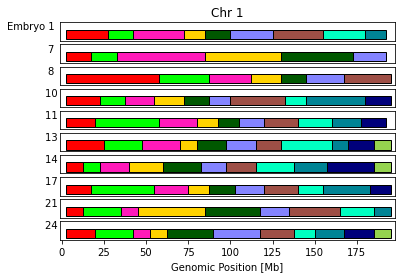

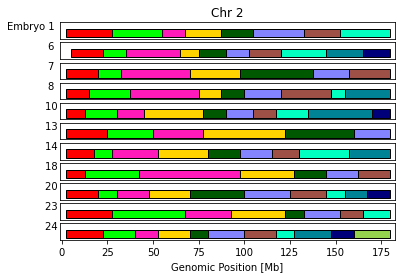

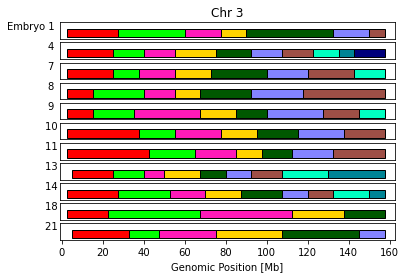

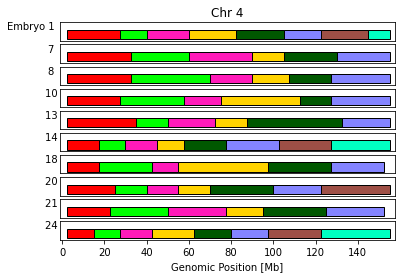

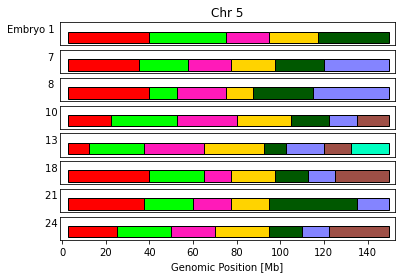

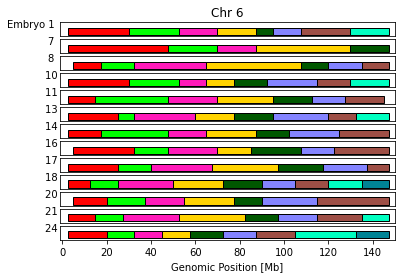

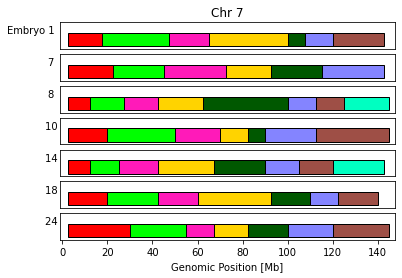

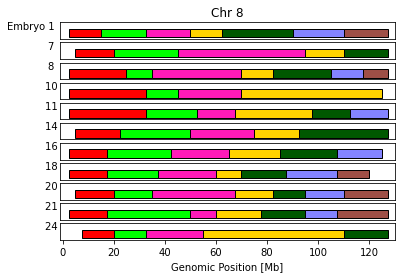

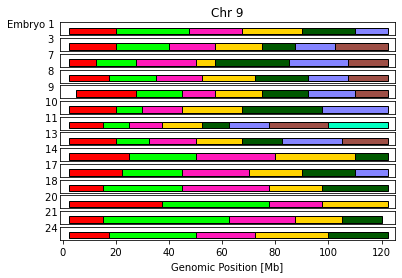

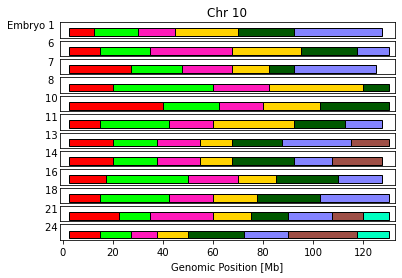

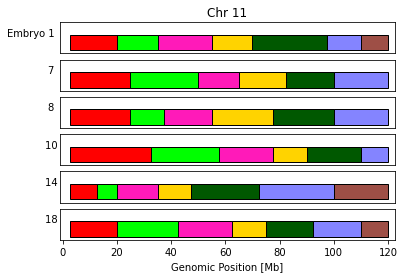

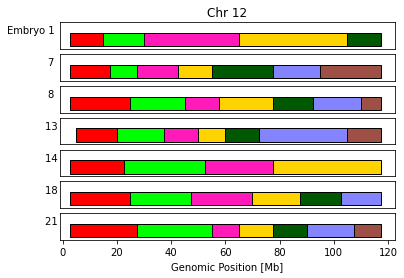

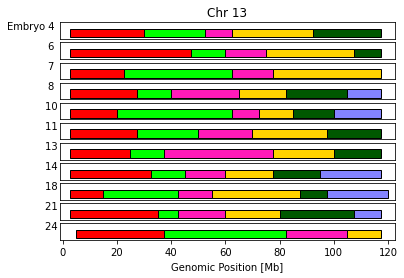

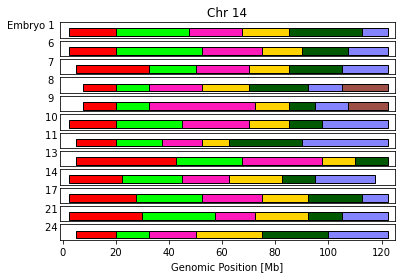

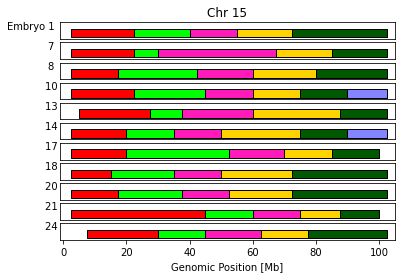

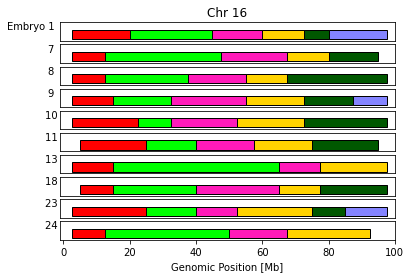

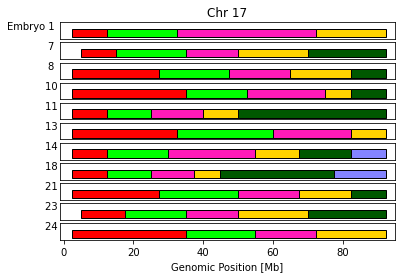

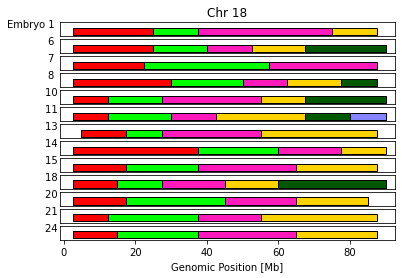

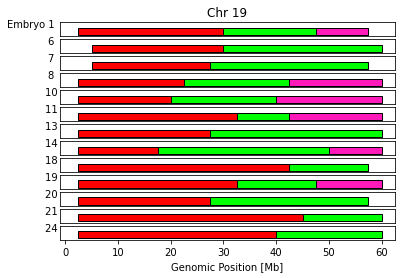

In [17]:
draw_scd_ensemble(matrices, clusters, num_chrs)

# 6. Lamin Profile Analysis

Joint analysis of nuclear lamina and SCDs.

In [18]:
def do_lamin_profile_analysis(matrices, clusters, 
                              num_scaled_bins=22, 
                              resolution = 2.5*10**6,
                              attribute = "dist_to_lamin"):
    """
    Perform SCD distance profile anaysis as follows:
    1. Call SCDs
    2. Using a fixed number of bins for all SCDs, construct scaled SCD 
       distance profilesby binning reads falling between pairs of SCD boundaries 
       according to their relative genomic positions between the boundaries,
       and the recording an attribute of the reads (e.g lamin distance).
    3. Aggregate over all SCDs to constructed the expected distance profile.
    4. Test alternate (shifted) placements of SCD boundaries to construct the
       expected scaled distance profile.
    5. Construct and plot the observed-over-expected distance profile.
    """
    
    #To compare across SCDs, bins corresponding to the
    #relative positions of reads falling between SCD peaks,
    #aggregated across all SCDs.
    scd_scaled_dists, shifted_scaled_dists = [], []
    for i in range(num_scaled_bins): 
        scd_scaled_dists.append([])
        shifted_scaled_dists.append([])
        
    #Do the scaling
    for i in range(len(clusters)):

        #Analyze one chromosome at a time
        A, cluster = matrices[i], clusters[i]
        #Lists of genomic positions and attribute values for the observed reads.
        P = cluster["pos"].values
        L = cluster[attribute].values
        
        #Get SCD peaks and convert to basepairs
        peaks, dists = scd.get_scd_peaks(matrices[i])
        peaks = peaks*resolution

        #Generate observed scaled lamin distance profile for a single chromosome
        d = scd.get_scaled_dists(peaks[1:-1], P, L, resolution, num_scaled_bins)
        #Generated expected scaled lamin distance profile for that chromosome
        ds = scd.get_shifted_scaled_dists(A, peaks, P, L, resolution, num_scaled_bins)
        #Aggregate across chromosome profiles
        for j in range(len(scd_scaled_dists)):
            scd_scaled_dists[j].extend(d[j])
            shifted_scaled_dists[j].extend(ds[j])
            
    #Increase sampling depth by mirror right half of scaled profiles 
    #to present profile on [0,0.5] rather than [0,1].
    scd_mirrored = scd.mirror_distance_vector(scd_scaled_dists) 
    scd_shifted_mirrored = scd.mirror_distance_vector(shifted_scaled_dists)
    
    #Make observed-over-expected profile using observed and expected profiles
    OEs, CIs = scd.get_oe_distances(scd_mirrored, scd_shifted_mirrored)
    
    #Plot the profile
    fig, ax = scd.make_oe_lamin_plot(OEs,CIs)
    
    return fig, ax

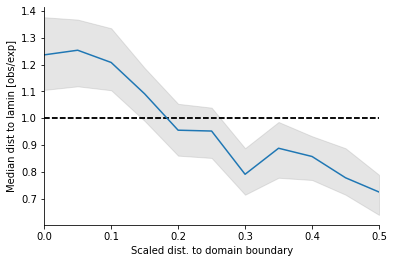

In [19]:
fig, ax = do_lamin_profile_analysis(matrices, clusters)
plt.savefig("./panel_g_profile/profile.svg")